# Transformer

[Stock predictions with state-of-the-art Transformer and Time Embeddings](https://towardsdatascience.com/stock-predictions-with-state-of-the-art-transformer-and-time-embeddings-3a4485237de6)

In [70]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [71]:
sns.set()

In [39]:
class Time2Vector(keras.layers.Layer):
    def __init__(self, seqlen, **kwargs):
        super(Time2Vector, self).__init__()
        self.seqlen = int(seqlen)
        
    def build(self, input_shape):
        self.lweights = self.add_weight(
            name='weight_linear',
            shape=(self.seqlen,),
            initializer='uniform',
            trainable=True)
        self.lbias = self.add_weight(
            name='bias_linear',
            shape=(self.seqlen,),
            initializer='uniform',
            trainable=True)
        self.pweights = self.add_weight(
            name='weight_periodic',
            shape=(self.seqlen,),
            initializer='uniform',
            trainable=True)
        self.pbias = self.add_weight(
            name='bias_periodic',
            shape=(self.seqlen,),
            initializer='uniform',
            trainable=True)
        
    def call(self, x):
        # (batch, seqlen, nfeat) -> (batch, seqlen)
        x = tf.math.reduce_mean(x[:,:,:4], axis=-1)
        # (batch, seqlen) -> (batch, seqlen, 1)
        lterm = self.lweights * x + self.lbias
        lterm = tf.expand_dims(lterm, axis=-1)
        pterm = self.pweights * x + self.pbias
        pterm = tf.math.sin(pterm)
        pterm = tf.expand_dims(pterm, axis=-1)
        # (batch, seqlen, 1) + (batch, seqlen, 1) => (batch, seqlen, 2)
        return tf.concat([lterm, pterm], axis=-1)

In [4]:
class SingleAttention(keras.layers.Layer):
    def __init__(self, d_key, d_value):
        super(SingleAttention, self).__init__()
        self.d_key = d_key
        self.d_value = d_value
        
    def build(self, input_shape):
        self.query = keras.layers.Dense(
            self.d_key,
            input_shape=input_shape,
            kernel_initializer='glorot_uniform',
            bias_initializer='glorot_uniform')
        self.key = keras.layers.Dense(
            self.d_key,
            input_shape=input_shape,
            kernel_initializer='glorot_uniform',
            bias_initializer='glorot_uniform')
        self.value = keras.layers.Dense(
            self.d_value,
            input_shape=input_shape,
            kernel_initializer='glorot_uniform',
            bias_initializer='glorot_uniform')
        
    def call(self, inputs):
        q = self.query(inputs[0])
        k = self.key(inputs[1])
        v = self.value(inputs[2])
        
        attention_weights = tf.matmul(q, k, transpose_b=True)
        attention_weights = tf.map_fn(lambda x: x / np.sqrt(self.d_key), attention_weights)
        attention_weights = tf.nn.softmax(attention_weights, axis=-1)
        
        return tf.matmul(attention_weights, v)

In [50]:
class MultiAttention(keras.layers.Layer):
    def __init__(self, d_key, d_value, n_heads, **kwargs):
        super(MultiAttention, self).__init__()
        self.d_key = d_key
        self.d_value = d_value
        self.n_heads = n_heads
        
    def build(self, input_shape):
        self.heads = [SingleAttention(self.d_key, self.d_value) for _ in range(self.n_heads)]
        self.linear = keras.layers.Dense(
            14,
            input_shape=input_shape,
            kernel_initializer='glorot_uniform',
            bias_initializer='glorot_uniform')
        
    def call(self, inputs):
        attentions = [head(inputs) for head in self.heads]
        return self.linear(tf.concat(attentions, axis=-1))

In [52]:
class TransformerEncoder(keras.layers.Layer):
    def __init__(self, d_key, d_value, n_heads, n_filters, dropout_rate=0.1, **kwargs):
        super(TransformerEncoder, self).__init__()
        self.d_key = d_key
        self.d_value = d_value
        self.n_heads = n_heads
        self.n_filters = n_filters
        self.dropout_rate = dropout_rate
        
    def build(self, input_shape):
        self.attention_multi = MultiAttention(self.d_key, self.d_value, self.n_heads)
        self.attention_dropout = keras.layers.Dropout(self.dropout_rate)
        self.attention_normalize = keras.layers.LayerNormalization(input_shape=input_shape, epsilon=1e-6)
        
        self.ff_conv1D_1 = keras.layers.Conv1D(filters=self.n_filters, kernel_size=1, activation='relu')
        self.ff_conv1D_2 = keras.layers.Conv1D(filters=14, kernel_size=1)
        self.ff_dropout = keras.layers.Dropout(self.dropout_rate)
        self.ff_normalize = keras.layers.LayerNormalization(input_shape=input_shape, epsilon=1e-6)
        
    def call(self, inputs):
        L_attn = self.attention_multi(inputs)
        L_attn = self.attention_dropout(L_attn)
        L_attn = self.attention_normalize(L_attn + inputs[0])
        
        L_ff = self.ff_conv1D_1(L_attn)
        L_ff = self.ff_conv1D_2(L_ff)
        L_ff = self.ff_dropout(L_ff)
        L_ff = self.ff_normalize(L_ff + inputs[0])
        
        return L_ff

In [191]:
def create_transformer(seqlen, n_feats, d_key, d_value, n_heads, n_filters):
    input_layer = keras.layers.Input(shape=(seqlen, n_feats), name='Input_Layer')
    time_embedded_layer = Time2Vector(seqlen, name='Time_Embedded_Layer')(input_layer)
    
    x = keras.layers.Concatenate(axis=-1, name='Concatenation_Layer')([input_layer, time_embedded_layer])
    x = TransformerEncoder(d_key, d_value, n_heads, n_filters, name='Transformer_Layer 1')((x, x, x))
    x = TransformerEncoder(d_key, d_value, n_heads, n_filters, name='Transformer_Layer 2')((x, x, x))
    x = TransformerEncoder(d_key, d_value, n_heads, n_filters, name='Transformer_Layer 3')((x, x, x))
    
    x = keras.layers.GlobalAveragePooling1D(data_format='channels_first', name='Global_Average_Pooling_Layer')(x)
    x = keras.layers.Dropout(0.1, name='Dropout_Layer_1')(x)
    
    x = keras.layers.Dense(64, activation='relu', name='Dense_Layer')(x)
    x = keras.layers.Dropout(0.1, name='Dropout_Layer_2')(x)
    
    output_layer = keras.layers.Dense(1, activation='linear', name='Output_Layer')(x)
    
    model = keras.models.Model(inputs=input_layer, outputs=output_layer)
    opt = keras.optimizers.Adam(learning_rate=0.01)
    model.compile(loss='mse', optimizer=opt, metrics=['mae', 'mape'])
    
    return model

In [12]:
df = pd.read_csv('SSE50_data.csv', index_col='Date')

In [13]:
df

Open       High        Low      Close      Volume        Amount  \
Date                                                                            
1/19/10  2424.4690  2450.2810  2424.1610  2432.7130  2782907600  3.754464e+10   
1/20/10  2436.6470  2439.4680  2356.1610  2359.4850  3474848500  4.572057e+10   
1/21/10  2362.5970  2391.5080  2346.1480  2377.7530  2919614700  3.780439e+10   
1/22/10  2344.9730  2398.9890  2317.4810  2380.0550  4063927200  4.904208e+10   
1/25/10  2355.3570  2389.6270  2350.0090  2353.4710  2074988000  2.643013e+10   
...            ...        ...        ...        ...         ...           ...   
5/26/21  3656.3403  3678.0671  3643.9848  3657.1898  3455939600  9.658566e+10   
5/27/21  3645.4823  3709.0023  3628.9596  3664.9417  2987912000  8.514700e+10   
5/28/21  3663.8753  3689.2479  3630.5739  3659.2957  2868284600  8.046883e+10   
5/31/21  3652.8877  3652.8924  3615.4225  3650.2245  2632840100  7.791793e+10   
6/1/21   3641.9690  3652.9485  3608.2042  3650.9034  2816154700  8.285057e+10   

               MA10        SMA10        EMA10        WMA10      RSI10  \
Date                                                                    
1/19/10  2464.61850  2438.954955  2466.464064  2445.673491  57.356961   
1/20/10  2453.49070  2436.235592  2447.013325  2439.872491  21.140561   
1/21/10  2438.03780  2411.790807  2434.420538  2422.780545  13.320917   
1/22/10  2429.43730  2401.647457  2424.535895  2411.819673  36.356681   
1/25/10  2420.82630  2395.526910  2411.615005  2402.841073  47.375317   
...             ...          ...          ...          ...        ...   
5/26/21  3509.72153  3542.175518  3545.234937  3529.206900  80.199454   
5/27/21  3530.65434  3575.720146  3566.999803  3556.019313  55.425479   
5/28/21  3555.75965  3605.004834  3583.780875  3580.435196  92.556546   
5/31/21  3571.38552  3622.333736  3595.861534  3599.259933  86.804920   
6/1/21   3582.41672  3630.638363  3605.869146  3613.594293  69.497758   

                VWAP  
Date                  
1/19/10  2468.899904  
1/20/10  2462.052875  
1/21/10  2456.259144  
1/22/10  2448.815045  
1/25/10  2445.420419  
...              ...  
5/26/21  2489.672103  
5/27/21  2490.025884  
5/28/21  2490.363015  
5/31/21  2490.666961  
6/1/21   2490.991280  

[2761 rows x 12 columns]

In [15]:
seqlen = 128

X, Y = [], []

for r in range(seqlen, df.shape[0]-5):
    X.append(df.iloc[r-seqlen:r,:].values)
    cprice_cur = df.iloc[r,3]
    cprice_fut = df.iloc[r+5,3]
    ret = (cprice_fut - cprice_cur) / cprice_cur
    Y.append(ret)

In [20]:
len(X)

2628

In [21]:
X[0].shape

(128, 12)

In [22]:
len(Y)

2628

In [27]:
n_train = int(np.round(len(X) * 0.8))
n_test = len(X) - n_train
n_val = int(np.round(n_train * 0.2))
n_train = n_train - n_val

In [28]:
print(n_train)
print(n_val)
print(n_test)

1682
420
526


In [59]:
X_train = np.array(X[0:n_train], dtype='float32')
X_val = np.array(X[n_train:n_train+n_val], dtype='float32')
X_test = np.array(X[-1-n_test:], dtype='float32')

Y_train = np.array(Y[0:n_train], dtype='float32')
Y_val = np.array(Y[n_train:n_train+n_val], dtype='float32')
Y_test = np.array(Y[-1-n_test:], dtype='float32')

In [32]:
X_train.shape

(1682, 128, 12)

In [33]:
X_val.shape

(420, 128, 12)

In [34]:
X_test.shape

(527, 128, 12)

In [60]:
Y_train.shape

(1682,)

In [61]:
Y_val.shape

(420,)

In [62]:
Y_test.shape

(527,)

In [55]:
model = create_transformer(X_train.shape[1], X_train.shape[2], 256, 256, 12, 256)

In [56]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_Layer (InputLayer)        [(None, 128, 12)]    0                                            
__________________________________________________________________________________________________
time2_vector_7 (Time2Vector)    (None, 128, 2)       512         Input_Layer[0][0]                
__________________________________________________________________________________________________
Concatenation_Layer (Concatenat (None, 128, 14)      0           Input_Layer[0][0]                
                                                                 time2_vector_7[0][0]             
__________________________________________________________________________________________________
transformer_encoder_5 (Transfor (None, 128, 14)      188756      Concatenation_Layer[0][0]    

In [63]:
model.fit(X_train, Y_train, batch_size=32, epochs=35, validation_data=(X_val, Y_val))

Epoch 1/35
53/53 [==============================] - 102s 2s/step - loss: 0.0013 - mae: 0.0255 - mape: 212.8108 - val_loss: 8.2556e-04 - val_mae: 0.0226 - val_mape: 137.5709
Epoch 2/35
53/53 [==============================] - 80s 1s/step - loss: 0.0013 - mae: 0.0253 - mape: 133.8222 - val_loss: 8.2258e-04 - val_mae: 0.0226 - val_mape: 107.3502
Epoch 3/35
53/53 [==============================] - 79s 2s/step - loss: 0.0013 - mae: 0.0254 - mape: 224.1835 - val_loss: 8.2333e-04 - val_mae: 0.0226 - val_mape: 102.6842
Epoch 4/35
53/53 [==============================] - 67s 1s/step - loss: 0.0013 - mae: 0.0253 - mape: 156.6132 - val_loss: 8.4150e-04 - val_mae: 0.0227 - val_mape: 175.4043
Epoch 5/35
53/53 [==============================] - 72s 1s/step - loss: 0.0013 - mae: 0.0254 - mape: 129.8425 - val_loss: 8.2265e-04 - val_mae: 0.0226 - val_mape: 121.2726
Epoch 6/35
53/53 [==============================] - 73s 1s/step - loss: 0.0013 - mae: 0.0253 - mape: 138.5580 - val_loss: 8.2229e-04 - val_

In [64]:
model.evaluate(X_train, Y_train)

53/53 [==============================] - 26s 493ms/step - loss: 0.0013 - mae: 0.0252 - mape: 117.0572


[0.001258360338397324, 0.025184065103530884, 117.05717468261719]

In [65]:
Y_pred = model.predict(X_test)

In [66]:
Y_pred

array([[0.00069226],
       [0.00069226],
       [0.00069226],
       [0.00069225],
       [0.00069226],
       [0.00069226],
       [0.00069226],
       [0.00069226],
       [0.00069226],
       [0.00069226],
       [0.00069226],
       [0.00069226],
       [0.00069226],
       [0.00069226],
       [0.00069225],
       [0.00069226],
       [0.00069226],
       [0.00069226],
       [0.00069226],
       [0.00069226],
       [0.00069226],
       [0.00069225],
       [0.00069225],
       [0.00069226],
       [0.00069225],
       [0.00069226],
       [0.00069226],
       [0.00069226],
       [0.00069226],
       [0.00069225],
       [0.00069226],
       [0.00069226],
       [0.00069226],
       [0.00069225],
       [0.00069226],
       [0.00069225],
       [0.00069226],
       [0.00069226],
       [0.00069226],
       [0.00069225],
       [0.00069226],
       [0.00069226],
       [0.00069226],
       [0.00069226],
       [0.00069226],
       [0.00069226],
       [0.00069226],
       [0.000

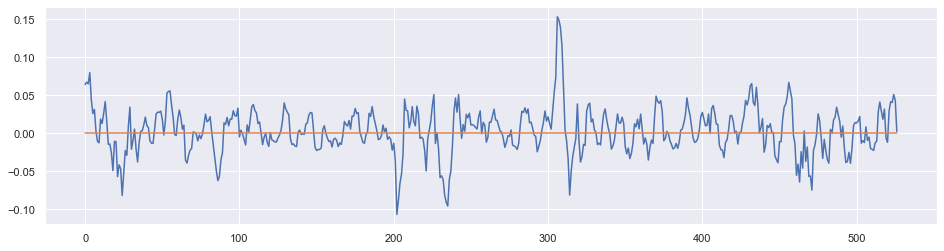

In [76]:
plt.figure(figsize=(16, 4))
plt.plot(np.arange(X_test.shape[0]), Y_test)
plt.plot(np.arange(X_test.shape[0]), Y_pred)

In [162]:
df_rolling = df.copy()
df_rolling[['Open', 'High', 'Low', 'Close', 'Volume']] = \
    df_rolling[['Open', 'High', 'Low', 'Close', 'Volume']].rolling(10).mean()
df_rolling['Open'] = df_rolling['Open'].pct_change()
df_rolling['High'] = df_rolling['High'].pct_change()
df_rolling['Low'] = df_rolling['Low'].pct_change()
df_rolling['Close'] = df_rolling['Close'].pct_change()

In [163]:
df_rolling.dropna(how='any', inplace=True)

In [165]:
seqlen = 128

X, Y = [], []

for r in range(seqlen, df_rolling.shape[0]):
    X.append(df_rolling.iloc[r-seqlen:r,:].values)
#     cprice_cur = df_rolling.iloc[r,3]
#     cprice_yest = df_rolling.iloc[r-1,3]
#     ret = (cprice_cur - cprice_yest) / cprice_yest
#     Y.append(ret)
    Y.append(df_rolling.iloc[r,3])

In [167]:
X_train = np.array(X[0:n_train], dtype='float32')
X_val = np.array(X[n_train:n_train+n_val], dtype='float32')
X_test = np.array(X[-1-n_test:], dtype='float32')

Y_train = np.array(Y[0:n_train], dtype='float32')
Y_val = np.array(Y[n_train:n_train+n_val], dtype='float32')
Y_test = np.array(Y[-1-n_test:], dtype='float32')

X_mins = [None for _ in range(X_train.shape[2])]
X_maxs = [None for _ in range(X_train.shape[2])]
for k in range(X_train.shape[0]):
    for j in range(X_train.shape[2]):
        X_min = np.min(X_train[k,:,j])
        X_max = np.max(X_train[k,:,j])
        if X_mins[j] is not None:
            X_mins[j] = min(X_mins[j], X_min)
            X_maxs[j] = max(X_maxs[j], X_max)
        else:
            X_mins[j] = X_min
            X_maxs[j] = X_max
        
Y_min = np.min(Y_train)
Y_max = np.max(Y_train)

X_mins = np.array(X_mins, dtype='float32')
X_maxs = np.array(X_maxs, dtype='float32')
Y_min = np.array(Y_min, dtype='float32')
Y_max = np.array(Y_max, dtype='float32')

# Normalize
X_train_normalized = []
X_val_normalized = []
X_test_normalized = []

Y_train_normalized = []
Y_val_normalized = []
Y_test_normalized = []

for k in range(X_train.shape[0]):
    Xsub = X_train[k]
    X_train_normalized.append((Xsub - X_mins) / (X_maxs - X_mins))
Y_train_normalized = (Y_train - Y_min) / (Y_max - Y_min)

for k in range(X_val.shape[0]):
    Xsub = X_val[k]
    X_val_normalized.append((Xsub - X_mins) / (X_maxs - X_mins))
Y_val_normalized = (Y_val - Y_min) / (Y_max - Y_min)

for k in range(X_test.shape[0]):
    Xsub = X_test[k]
    X_test_normalized.append((Xsub - X_mins) / (X_maxs - X_mins))
Y_test_normalized = (Y_test - Y_min) / (Y_max - Y_min)
    
X_train_normalized = np.array(X_train_normalized, dtype='float32')
X_val_normalized = np.array(X_val_normalized, dtype='float32')
X_test_normalized = np.array(X_test_normalized, dtype='float32')
Y_train_normalized = np.array(Y_train_normalized, dtype='float32')
Y_val_normalized = np.array(Y_val_normalized, dtype='float32')
Y_test_normalized = np.array(Y_test_normalized, dtype='float32')

In [168]:
X_train_normalized.shape

(1682, 128, 12)

In [169]:
X_train_normalized[0]

array([[0.33120888, 0.2840799 , 0.37227526, ..., 0.44603643, 0.2445246 ,
        1.        ],
       [0.32282358, 0.30476907, 0.40994793, ..., 0.4361993 , 0.02329036,
        0.98990464],
       [0.40456137, 0.340505  , 0.46470866, ..., 0.43442518, 0.5663229 ,
        0.98389804],
       ...,
       [0.527986  , 0.47345874, 0.548842  , ..., 0.28954062, 0.39859653,
        0.5763097 ],
       [0.48028982, 0.39933416, 0.54498684, ..., 0.28528804, 0.70030165,
        0.57379204],
       [0.43244052, 0.37611815, 0.48183894, ..., 0.28154445, 0.4860579 ,
        0.5710824 ]], dtype=float32)

In [170]:
Y_train_normalized.shape

(1682,)

In [171]:
Y_train_normalized[0]

0.4483611

In [192]:
# model = create_transformer(
#     X_train.shape[1],
#     X_train.shape[2],
#     256, 256, 12, 256)
# model.fit(
#     X_train,
#     Y_train,
#     batch_size=32,
#     epochs=10,
#     validation_data=(X_val, Y_val))
model = create_transformer(
    X_train_normalized.shape[1],
    X_train_normalized.shape[2],
    256, 256, 12, 256)
model.fit(
    X_train_normalized,
    Y_train_normalized,
    batch_size=32,
    epochs=15,
    validation_data=(X_val_normalized, Y_val_normalized))

Epoch 1/15
53/53 [==============================] - 159s 2s/step - loss: 0.0196 - mae: 0.0920 - mape: 323093.9062 - val_loss: 0.0073 - val_mae: 0.0708 - val_mape: 13.6083
Epoch 2/15
53/53 [==============================] - 66s 1s/step - loss: 0.0095 - mae: 0.0707 - mape: 312900.6562 - val_loss: 0.0049 - val_mae: 0.0556 - val_mape: 11.1922
Epoch 3/15
53/53 [==============================] - 62s 1s/step - loss: 0.0092 - mae: 0.0691 - mape: 294542.9062 - val_loss: 0.0048 - val_mae: 0.0542 - val_mape: 11.0379
Epoch 4/15
53/53 [==============================] - 62s 1s/step - loss: 0.0092 - mae: 0.0697 - mape: 309045.3750 - val_loss: 0.0046 - val_mae: 0.0527 - val_mape: 11.0758
Epoch 5/15
53/53 [==============================] - 63s 1s/step - loss: 0.0089 - mae: 0.0677 - mape: 301309.1562 - val_loss: 0.0052 - val_mae: 0.0575 - val_mape: 11.4546
Epoch 6/15
53/53 [==============================] - 63s 1s/step - loss: 0.0092 - mae: 0.0691 - mape: 302948.7812 - val_loss: 0.0057 - val_mae: 0.0610

In [193]:
# Y_pred = model.predict(X_train)
Y_pred = model.predict(X_test_normalized)

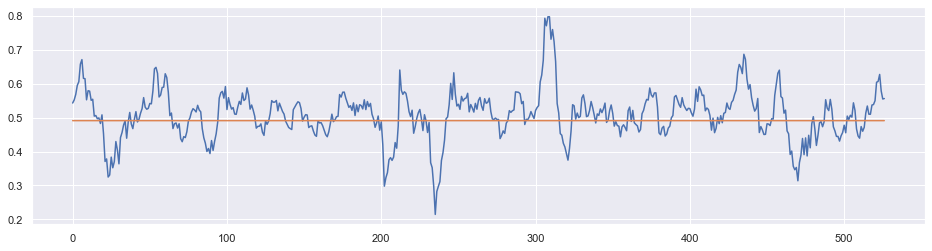

In [194]:
plt.figure(figsize=(16, 4))
plt.plot(np.arange(X_test_normalized.shape[0]), Y_test_normalized)
plt.plot(np.arange(X_test_normalized.shape[0]), Y_pred)

In [180]:
Y_test

array([ 2.42732302e-03,  2.93128775e-03,  3.83387855e-03,  5.31495037e-03,
        5.92061598e-03,  8.79362784e-03,  9.54247452e-03,  6.47026952e-03,
        6.41851360e-03,  2.95459363e-03,  4.44528181e-03,  4.37400723e-03,
        2.86949403e-03,  3.04740504e-03,  2.75880011e-04,  3.80522833e-04,
       -1.42705147e-04, -1.44968180e-05, -9.28585359e-04,  4.86572302e-04,
       -2.61255167e-03, -7.15220440e-03, -6.73856260e-03, -9.70476586e-03,
       -9.36948042e-03, -6.44282065e-03, -8.18905607e-03, -7.18017388e-03,
       -3.88938771e-03, -5.28610498e-03, -7.54203042e-03, -3.24204355e-03,
       -2.41292734e-03, -1.18292635e-03, -4.68015700e-04, -3.34347179e-03,
       -6.86683168e-04,  8.80658277e-04, -1.01409806e-03, -1.77330547e-03,
       -2.29760713e-04,  1.01339084e-03, -6.76718599e-04, -2.25076714e-04,
        7.63766118e-04,  1.51509198e-03,  3.31336586e-03,  1.74788618e-03,
        1.40975404e-03,  1.55004405e-03,  2.35031405e-03,  2.29526218e-03,
        4.38647484e-03,  

In [181]:
Y_pred

array([[0.00059079],
       [0.0005908 ],
       [0.00059079],
       [0.00059077],
       [0.00059085],
       [0.00059085],
       [0.00059078],
       [0.00059083],
       [0.00059083],
       [0.00059081],
       [0.00059082],
       [0.00059079],
       [0.00059082],
       [0.00059071],
       [0.0005908 ],
       [0.00059078],
       [0.00059075],
       [0.00059083],
       [0.00059076],
       [0.00059081],
       [0.00059082],
       [0.00059078],
       [0.00059074],
       [0.00059074],
       [0.00059065],
       [0.00059068],
       [0.00059078],
       [0.00059078],
       [0.00059085],
       [0.00059076],
       [0.00059085],
       [0.00059088],
       [0.00059083],
       [0.00059085],
       [0.0005908 ],
       [0.00059075],
       [0.00059071],
       [0.00059076],
       [0.00059081],
       [0.00059083],
       [0.00059073],
       [0.00059086],
       [0.00059089],
       [0.00059089],
       [0.00059076],
       [0.00059083],
       [0.00059083],
       [0.000

In [185]:
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_Layer (InputLayer)        [(None, 128, 12)]    0                                            
__________________________________________________________________________________________________
time2_vector_17 (Time2Vector)   (None, 128, 2)       512         Input_Layer[0][0]                
__________________________________________________________________________________________________
Concatenation_Layer (Concatenat (None, 128, 14)      0           Input_Layer[0][0]                
                                                                 time2_vector_17[0][0]            
__________________________________________________________________________________________________
transformer_encoder_35 (Transfo (None, 128, 14)      188756      Concatenation_Layer[0][0] 

In [190]:
model.get_layer('transformer_encoder_35').get_weights()

[array([[-0.13897355, -0.14253095,  0.03498892, ..., -0.13315721,
          0.0805251 ,  0.08181955],
        [-0.08449607,  0.11932404,  0.00273687, ...,  0.1132236 ,
          0.14574681, -0.1007016 ],
        [-0.13257031, -0.11836263, -0.05051797, ..., -0.0609195 ,
         -0.11624326,  0.00946757],
        ...,
        [-0.0581498 ,  0.04522532,  0.074983  , ..., -0.06270587,
          0.08338434, -0.0866327 ],
        [-0.1472567 , -0.0816975 ,  0.06079461, ...,  0.01748712,
          0.11098523,  0.00977063],
        [ 0.0403132 , -0.08999608, -0.12906064, ..., -0.05568603,
         -0.08034611,  0.01140241]], dtype=float32),
 array([-4.28825989e-02,  5.62617108e-02,  2.75848284e-02,  7.12363645e-02,
        -5.66179343e-02, -1.32880062e-02, -8.53932798e-02, -8.00076127e-03,
        -8.45277756e-02,  6.16446361e-02,  6.10610023e-02,  4.52418551e-02,
        -5.59390634e-02, -4.19965312e-02, -4.83718514e-02,  8.61334428e-02,
         2.28515267e-03, -7.29519874e-02, -1.91175565e